Задание: нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.

Идея решения задачи от заказчика:

    1. Создать модель предсказания ДТП (целевое значение — at_fault (виновник) в таблице parties)
        - Для модели выбрать тип виновника — только машина (car).
        - Выбрать случаи, когда ДТП привело к любым повреждениям транспортного средства, кроме типа SCRATCH (царапина).
        - Для моделирования ограничиться данными за 2012 год — они самые свежие.
        - Обязательное условие — учесть фактор возраста автомобиля.
    2. На основе модели исследовать основные факторы ДТП.
    3. Понять, помогут ли результаты моделирования и анализ важности факторов ответить на вопросы:
        - Возможно ли создать адекватную системы оценки водительского риска при выдаче авто?
        - Какие ещё факторы нужно учесть?
        - Нужно ли оборудовать автомобиль какими-либо датчиками или камерой?

Алгоритм работы:<br>
1. Загрузим таблицы sql <br>
2. Проведем первичное исследование таблиц <br>
3. Проведем статистический анализ факторов ДТП <br>
4. Создадим модели для оценки водительского риска <br>
5. Найдем лучшую модель <br>
6. Сделаем общий вывод по модели <br>

Краткое описание таблиц:

    collisions — общая информация о ДТП
    Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.
    parties — информация об участниках ДТП
    Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number.
    vehicles — информация о пострадавших машинах
    Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

## Загрузим и посмотрим таблицы

библиотеки

In [159]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib as mlt
mlt.rcParams['figure.figsize'] = (10, 5)

plt.style.use("fivethirtyeight")

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import (precision_recall_curve,
                            PrecisionRecallDisplay)

from sklearn.impute import SimpleImputer

from torch.utils.data import TensorDataset
import torch 
import torch.nn as nn
import random

from sklearn.metrics import log_loss
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import SelectKBest, chi2
from catboost import Pool, cv

from sqlalchemy import create_engine 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

создадим соединение

In [85]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string) 

посмотрим таблицы

In [86]:
query = '''
SELECT *
FROM parties
Limit 5;
'''

sample_parties = pd.read_sql_query(query, con=engine) 
sample_parties.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


In [87]:
query = '''
SELECT *
FROM collisions
Limit 5;
'''

sample_collision = pd.read_sql_query(query, con=engine) 
sample_collision.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


In [88]:
query = '''
SELECT *
FROM vehicles
Limit 5;
'''

sample_vehicles = pd.read_sql_query(query, con=engine) 
sample_vehicles.head()

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


Во всех таблицах есть необходимые поля. Общий ключ case_id присутствует

## Cтатистический анализ факторов ДТП

посмотрим в какие месяцы наибольшее число аварий

In [89]:
query = '''
SELECT 
EXTRACT(MONTH FROM collision_date::date) as month,
count(*) as count
FROM collisions
WHERE collision_damage != 'scratch'
GROUP BY EXTRACT(MONTH FROM collision_date::date)
'''

collision_count_month = pd.read_sql_query(query, con=engine) 
collision_count_month.sort_values(by="count", ascending=False)

,month,count
2,3.0,104518
0,1.0,98974
4,5.0,98725
3,4.0,97912
1,2.0,96616
9,10.0,84148
11,12.0,80218
8,9.0,79288
7,8.0,79067
5,6.0,78172


<AxesSubplot:xlabel='month', ylabel='count'>

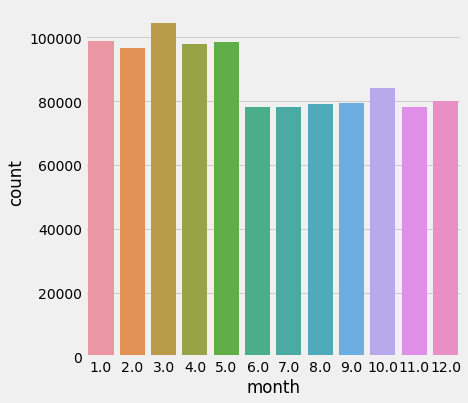

In [90]:
fig, ax = plt.subplots(figsize=(6,6))
sns.barplot(data=collision_count_month, x="month", y="count")


в первые 5 месяцев аварий больше, чем в остальном периоде

Посмотрим, в скольких случаях водитель был под воздействием алкоголя или наркотических веществ

In [91]:
query = '''
SELECT 
      party_drug_physical,
      party_sobriety,
      count(*) as count
FROM parties
WHERE party_type = 'car' and at_fault = 1
GROUP BY party_drug_physical, party_sobriety
'''

party_drug_physical_count = pd.read_sql_query(query, con=engine) 
party_drug_physical_count.sort_values(by="count", ascending=False)

,party_drug_physical,party_sobriety,count
20,None,had not been drinking,886627
0,G,impairment unknown,178697
19,None,"had been drinking, under influence",101212
17,None,"had been drinking, impairment unknown",15230
21,None,None,11414
6,not applicable,not applicable,10954
18,None,"had been drinking, not under influence",10811
16,under drug influence,None,8877
11,sleepy/fatigued,None,5697
10,sleepy/fatigued,had not been drinking,5597


Как мы видим, в большинстве случаев водитель не находился в состоянии опьянения или под воздействием наркотиков. C большим отрывом идет состояние опьянения. Совсем небольшая часть - наркотическое состояние

Проведем анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП 

In [92]:
query = '''
SELECT 
      c.road_surface,
      Count(*) as count_insurance,
      AVG(p.insurance_premium) as avg_insurance,
      SUM(p.insurance_premium) as sum_insurance
FROM parties as p
INNER JOIN collisions as c ON p.case_id = c.case_id
WHERE party_type = 'car' and at_fault = 1
GROUP BY c.road_surface
'''

insurance_on_road_surface = pd.read_sql_query(query, con=engine) 
insurance_on_road_surface.sort_values(by="sum_insurance", ascending=False)


,road_surface,count_insurance,avg_insurance,sum_insurance
0,dry,1097628,37.408230,35277869
3,wet,125545,35.483292,3909691
4,None,9612,37.452515,286699
2,snowy,6603,39.545584,248979
1,slippery,962,36.356971,30249


наибольшее кол-во происшедствий происходит на сухой дороге. Средний размер выплат примерно одинаков

Посмотрим, как влияет возраст автомобиля на кол-во аварий

In [93]:
query = '''
SELECT 
      v.vehicle_age,
      Count(*) as count
FROM parties as p
INNER JOIN Vehicles as v ON p.case_id = v.case_id
WHERE party_type = 'car' and at_fault = 1
GROUP BY v.vehicle_age
'''

vehicle_age = pd.read_sql_query(query, con=engine) 
vehicle_age.sort_values(by="count", ascending=False)

,vehicle_age,count
3,3.0,161739
4,4.0,113439
5,5.0,94825
2,2.0,90712
6,6.0,75615
7,7.0,74998
8,8.0,68221
9,9.0,51525
0,0.0,35682
10,10.0,34157


<AxesSubplot:xlabel='vehicle_age', ylabel='count'>

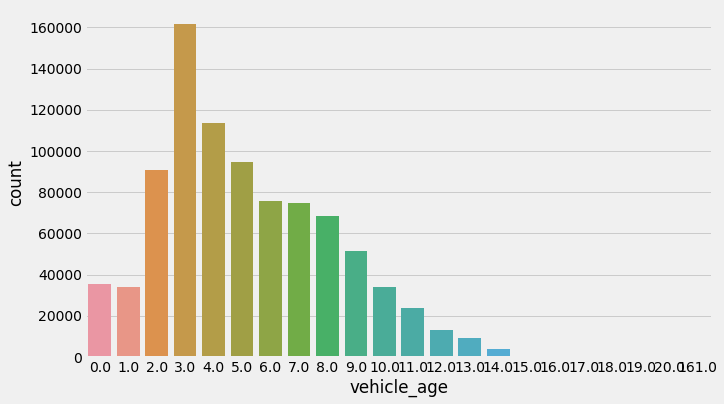

In [94]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=vehicle_age, x="vehicle_age", y="count")

С повышением возраста, число аварий растет. При дальнейшем повышением возраста начинает снижаться - видимо, это связано с малым количеством таких автомобилей

Посмотрим, как влияет тип кузова автомобиля на кол-во аварий

In [95]:
query = '''
SELECT 
      v.vehicle_type,
      Count(*) as count
FROM parties as p
INNER JOIN Vehicles as v ON p.case_id = v.case_id
WHERE party_type = 'car' and at_fault = 1
GROUP BY v.vehicle_type
'''

vehicle_type = pd.read_sql_query(query, con=engine) 
vehicle_type.sort_values(by="count", ascending=False)

,vehicle_type,count
4,sedan,449631
0,coupe,417097
1,hatchback,26208
2,minivan,13497
3,other,758


<AxesSubplot:xlabel='vehicle_type', ylabel='count'>

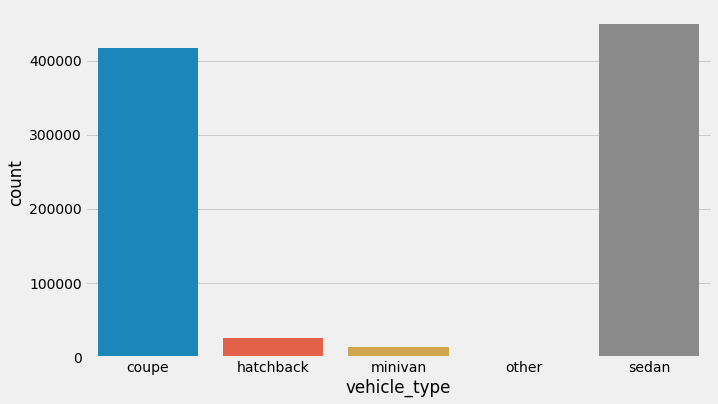

In [96]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=vehicle_type, x="vehicle_type", y="count")

Sedan и coupe находятся в топе. Хотя, они и более распространены

Посмотрим, как влияет освещенность дороги

In [97]:
query = '''
SELECT 
      c.lighting,
      Count(*) as count
FROM parties as p
INNER JOIN collisions as c ON p.case_id = c.case_id
WHERE party_type = 'car' and at_fault = 1
GROUP BY c.lighting
'''

lighting = pd.read_sql_query(query, con=engine) 
lighting.sort_values(by="count", ascending=False)

,lighting,count
3,daylight,836676
1,dark with street lights,257497
0,dark with no street lights,95371
4,dusk or dawn,41332
5,None,5764
2,dark with street lights not functioning,3710


<AxesSubplot:xlabel='lighting', ylabel='count'>

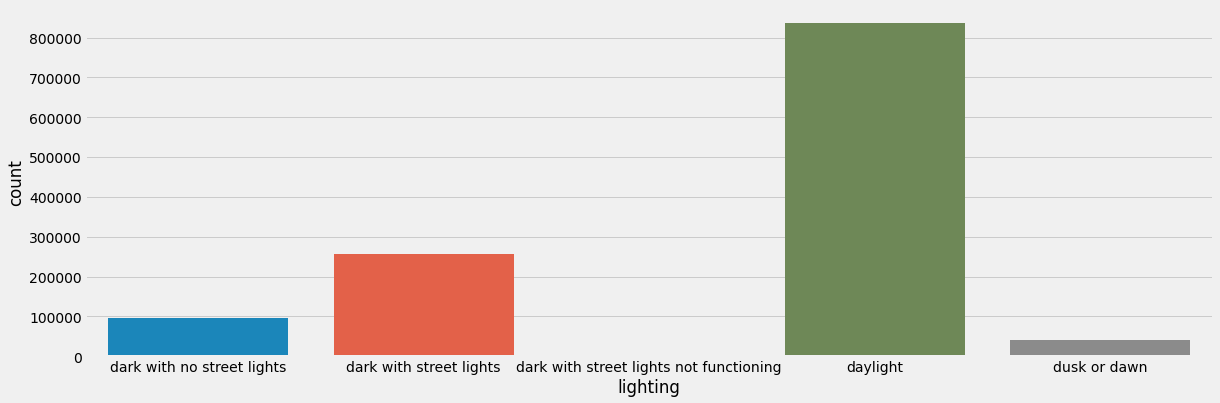

In [98]:
fig, ax = plt.subplots(figsize=(18,6))
sns.barplot(data=lighting, x="lighting", y="count")

Большинство аварий по вине водителя произошло при дневном свете

Выберем признаки для нашей модели. Состояния человека(сонливость, опьянения, наркотики) он сам не расскажет, а снять их удаленно довольно сложная задача, поэтому не будем их затрагивать. Во время посадки клиента в машину у нас есть информация о предполагаемом пути, погоде и технических хар-ках автомобиля. Их и будем использовать в нашей модели.  

In [99]:
columns = [
           'weather_1',     # Погода. Таблица collisions. cat
           'lighting',      # Освещение. Таблица collisions. cat
           'distance',      # Расстояние. Таблица collisions. num
           'location_type',      # Тип дороги. Таблица collisions. cat
           'cellphone_in_use',      # Наличие громкой связи. Таблица Parties. cat
           'vehicle_type',      # Тип кузова. Таблица Vechicles. cat
           'vehicle_transmission',      # Тип КПП. Таблица Vechicles. cat
           'vehicle_age',      # Возраст автомобиля. Таблица Vechicles. num

           # таргет
           'at_fault'
           
         ] 

сделаем запрос по выбранным параметрам. Отберем случаи за 2012 год и не будем включать тип повреждения 'scratch'

In [100]:
query = f'''
SELECT 
      c.{columns[0]},
      c.{columns[1]},
      c.{columns[2]},
      c.{columns[3]},
      p.{columns[4]},
      v.{columns[5]},
      v.{columns[6]},
      v.{columns[7]},
      p.{columns[8]}

FROM parties as p
INNER JOIN collisions as c ON p.case_id = c.case_id
INNER JOIN vehicles as v ON p.case_id = v.case_id
WHERE p.party_type = 'car'
      AND EXTRACT(YEAR FROM c.collision_date::date) = 2012
      AND c.collision_damage != 'scratch'
'''

data = pd.read_sql_query(query, con=engine) 
data.head()

,weather_1,lighting,distance,location_type,cellphone_in_use,vehicle_type,vehicle_transmission,vehicle_age,at_fault
0,clear,dark with street lights,0.0,ramp,NaN,coupe,manual,6.0,1
1,clear,dark with street lights,0.0,None,0.0,sedan,manual,3.0,1
2,clear,daylight,413.0,None,0.0,coupe,auto,13.0,1
3,clear,daylight,1079.0,None,0.0,coupe,manual,5.0,0
4,clear,daylight,1079.0,None,0.0,sedan,manual,3.0,0


Выделим числовые и категориальные признаки. Vehicle_age здесь представлен строго в годах - тоже будем считать его категориальным

In [101]:
num_features = ["distance"]
cat_features = ["weather_1", "lighting", "location_type", "cellphone_in_use", "vehicle_type", "vehicle_transmission", "vehicle_age"]
target = ["at_fault"]

In [102]:
X = data.copy()

рассмотрим числовые признаки

distance

In [103]:
X.distance.describe()

count    1.184110e+05
mean     7.320663e+02
std      6.902704e+03
min      0.000000e+00
25%      2.000000e+00
50%      1.180000e+02
75%      5.280000e+02
max      1.584000e+06
Name: distance, dtype: float64

<AxesSubplot:>

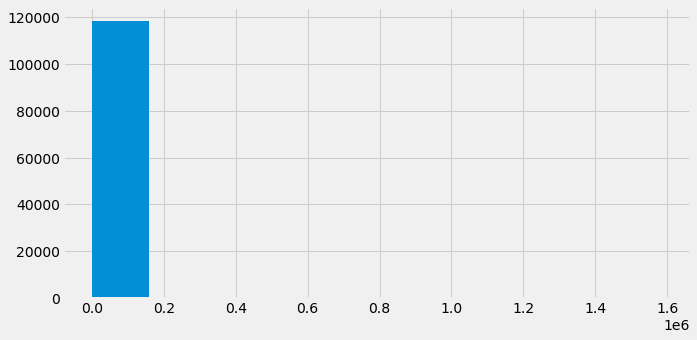

In [104]:
X.distance.hist()

<AxesSubplot:>

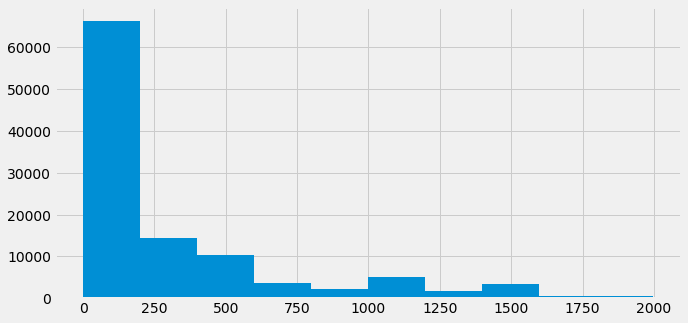

In [105]:
X[X["distance"] < 2000].distance.hist()

Уберем выбросы

In [106]:
X = X[X["distance"] < 1500]

In [107]:
X["distance"].isna().sum()

0

Рассмотрим категориальные признаки. Заменим пропуски

vehicle_age

<AxesSubplot:>

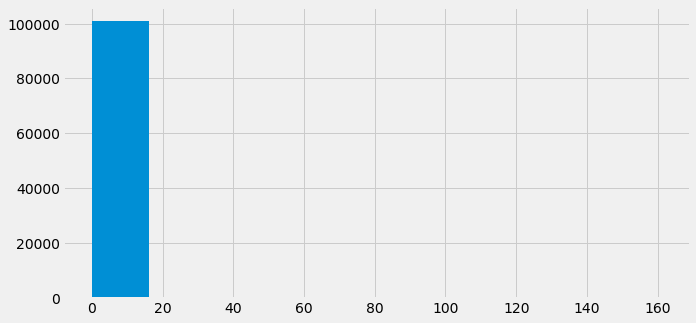

In [108]:
X.vehicle_age.hist()

<AxesSubplot:>

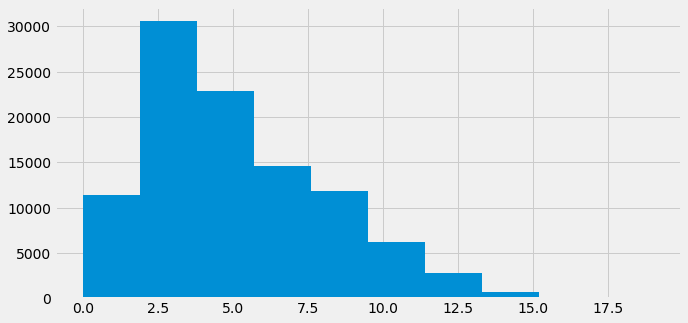

In [109]:
X[X["vehicle_age"] < 20].vehicle_age.hist()

Уберем выбросы

In [110]:
X = X[X["vehicle_age"] < 15]

In [111]:
X["vehicle_age"].isna().sum()

0

weather_1

In [112]:
X["weather_1"].unique()

array(['clear', 'fog', 'raining', 'cloudy', 'snowing', None, 'other',
       'wind'], dtype=object)

In [113]:
X["weather_1"] = X["weather_1"].fillna("clear")

In [114]:
X["weather_1"].unique()

array(['clear', 'fog', 'raining', 'cloudy', 'snowing', 'other', 'wind'],
      dtype=object)

In [115]:
X["weather_1"].value_counts()

clear      82606
cloudy     14210
raining     3623
fog          330
snowing      148
other         30
wind          23
Name: weather_1, dtype: int64

lighting

In [116]:
X["lighting"].unique()

array(['dark with street lights', 'daylight',
       'dark with no street lights', 'dusk or dawn', None,
       'dark with street lights not functioning'], dtype=object)

In [117]:
X["lighting"] = X["lighting"].fillna("daylight")

In [118]:
X["lighting"].unique()

array(['dark with street lights', 'daylight',
       'dark with no street lights', 'dusk or dawn',
       'dark with street lights not functioning'], dtype=object)

In [119]:
X["lighting"].value_counts()

daylight                                   71144
dark with street lights                    20215
dark with no street lights                  6161
dusk or dawn                                3184
dark with street lights not functioning      266
Name: lighting, dtype: int64

location_type

In [120]:
X["location_type"].unique()

array(['ramp', None, 'highway', 'intersection'], dtype=object)

In [121]:
X["location_type"] = X["location_type"].fillna("highway")

In [122]:
X["location_type"].unique()

array(['ramp', 'highway', 'intersection'], dtype=object)

In [123]:
X["location_type"].value_counts()

highway         92282
ramp             5919
intersection     2769
Name: location_type, dtype: int64

cellphone_in_use

In [124]:
X["cellphone_in_use"].unique()

array([nan,  0.,  1.])

In [125]:
X["cellphone_in_use"] = X["cellphone_in_use"].fillna(0)

In [126]:
X["cellphone_in_use"].unique()

array([0., 1.])

In [127]:
X["cellphone_in_use"].value_counts()

0.0    99086
1.0     1884
Name: cellphone_in_use, dtype: int64

vehicle_type

In [128]:
X["vehicle_type"].unique()

array(['coupe', 'sedan', 'hatchback', 'minivan', 'other'], dtype=object)

In [129]:
X["vehicle_type"].value_counts()

sedan        64524
coupe        30874
hatchback     3143
minivan       2378
other           51
Name: vehicle_type, dtype: int64

vehicle_transmission

In [130]:
X["vehicle_transmission"].unique()

array(['manual', 'auto', None], dtype=object)

In [131]:
X["vehicle_transmission"] = X["vehicle_transmission"].fillna("manual")

In [132]:
X["vehicle_transmission"].unique()

array(['manual', 'auto'], dtype=object)

In [133]:
X["vehicle_transmission"].value_counts()

manual    53045
auto      47925
Name: vehicle_transmission, dtype: int64

Посмотрим таргет

In [134]:
X["at_fault"].value_counts()

0    54064
1    46906
Name: at_fault, dtype: int64

таргет получился сбалансирован

приведем cellphone_in_use и vehicle_age к типу инту

In [135]:
X["cellphone_in_use"] = X["cellphone_in_use"].astype(int)
X["vehicle_age"] = X["vehicle_age"].astype(int)

In [136]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100970 entries, 0 to 118410
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   weather_1             100970 non-null  object 
 1   lighting              100970 non-null  object 
 2   distance              100970 non-null  float64
 3   location_type         100970 non-null  object 
 4   cellphone_in_use      100970 non-null  int32  
 5   vehicle_type          100970 non-null  object 
 6   vehicle_transmission  100970 non-null  object 
 7   vehicle_age           100970 non-null  int32  
 8   at_fault              100970 non-null  int64  
dtypes: float64(1), int32(2), int64(1), object(5)
memory usage: 6.9+ MB


Посмотрим корреляцию distance и vehicle_age с таргетом

In [137]:
X[['distance', 'vehicle_age', 'at_fault']].corr()['at_fault']

distance      -0.002576
vehicle_age   -0.010872
at_fault       1.000000
Name: at_fault, dtype: float64

Корреляция почти отсутствует

Отделим признаки от таргета

In [138]:
y = X[target]
X = X.drop(target, axis=1)

## Построение моделей

Сделаем ohe и скалирование для признаков

In [160]:
cat_transformer_linear = Pipeline([ ('ohe', OneHotEncoder(handle_unknown='ignore')) ])
num_transformer_linear = Pipeline([ ('simm', SimpleImputer(strategy='mean')), ('scaler', MinMaxScaler()) ])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer_linear, num_features),
        ("cat", cat_transformer_linear, cat_features)
    ]
)

In [165]:
sklearn.__version__

NameError: name 'sklearn' is not defined

In [163]:
X_prep = preprocessor.fit(X)

In [164]:
preprocessor.get_feature_names_out()

array(['num__distance', 'cat__weather_1_clear', 'cat__weather_1_cloudy',
       'cat__weather_1_fog', 'cat__weather_1_other',
       'cat__weather_1_raining', 'cat__weather_1_snowing',
       'cat__weather_1_wind', 'cat__lighting_dark with no street lights',
       'cat__lighting_dark with street lights',
       'cat__lighting_dark with street lights not functioning',
       'cat__lighting_daylight', 'cat__lighting_dusk or dawn',
       'cat__location_type_highway', 'cat__location_type_intersection',
       'cat__location_type_ramp', 'cat__cellphone_in_use_0',
       'cat__cellphone_in_use_1', 'cat__vehicle_type_coupe',
       'cat__vehicle_type_hatchback', 'cat__vehicle_type_minivan',
       'cat__vehicle_type_other', 'cat__vehicle_type_sedan',
       'cat__vehicle_transmission_auto',
       'cat__vehicle_transmission_manual', 'cat__vehicle_age_0',
       'cat__vehicle_age_1', 'cat__vehicle_age_2', 'cat__vehicle_age_3',
       'cat__vehicle_age_4', 'cat__vehicle_age_5', 'cat__vehicle_

Будем обучать catboost и lightlgm. Сделаем для них пайплайны с сетками для перебора гиперпараметров. Для lgm сделаем препроцессинг. Для catboost не будем его делать, т.к у него есть своя встроенная система обработки признаков перед обучением и, например, ohe сами разработчики советуют не делать, а оставить, как есть.

In [ ]:
pipelines = []
params = []
names = []

pipeline_lgm = Pipeline([('preprocessor', preprocessor), ('lgm', None)])  
pipeline_catboost = Pipeline([('cat', None)])  

param_lgm = [
    {
     'lgm': (LGBMClassifier(random_state=1),),
     'lgm__n_estimators': [100, 200],
     'lgm__max_depth': [4, 6],
     'lgm__learning_rate': [0.05, 0.1]
     }
]

param_catboost = [
     {'cat': (CatBoostClassifier(verbose=0, cat_features=cat_features, random_state=1, od_type='Iter', od_wait=10,),),
      'cat__n_estimators': [100, 200],
      'cat__max_depth': [4, 6],
      "cat__learning_rate": [0.05, 0.1]

      }
 ]

In [ ]:
names = ["lgm", "catboost"]
pipelines = [pipeline_lgm, pipeline_catboost]
params = [param_lgm, param_catboost]

Сделаем гридсерч с 3 фолдами. Т.к нам нужно понять вероятность того, будет ли виновником аварии водитель или нет, будем штрафовать модель в том случае, если вероятность события удаляется от 1 и 0 соответственно. Т.е модель должна давать как можно более аккуратную вероятность на тот или иной случай. Для этого выберем логлосс, как метрику качества. Выведем результаты обучения для каждой из типов моделей в виде табличек

In [ ]:
results_boosting = {}
for pipeline, param_grid, name in tqdm(zip(pipelines, params, names)):
    gs = GridSearchCV(pipeline,
                      param_grid,
                      scoring='neg_log_loss',
                      refit='neg_log_loss',
                      n_jobs=10,
                      cv=3)

    gs.fit(X, y)

    # top models table
    print('Top ' + name + ' models:')
    results_df = pd.DataFrame(gs.cv_results_)
    results_df = results_df.sort_values(by=["rank_test_score"])
    params = results_df["params"].apply(pd.Series).to_dict()
    keys = list(params.keys())
    results_df["lr"] = params[keys[1]].values()
    results_df["max_depth"] = params[keys[2]].values()
    results_df["max_estimators"] = params[keys[3]].values()

    display(results_df[['lr', "max_depth", "max_estimators", 'mean_test_score', 'mean_fit_time', 'rank_test_score']]
            .head(5)
            .rename(columns={'mean_test_score': 'cv_logloss_score'})
            .rename(columns={'rank_test_score': 'rank_cv_score'}))

    results_boosting[name] = gs


0it [00:00, ?it/s]

Top lgm models:


c:\Python3100\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Python3100\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,lr,max_depth,max_estimators,cv_logloss_score,mean_fit_time,rank_cv_score
2,0.05,6,100,-0.682576,0.611412,1
1,0.05,4,200,-0.682805,0.851747,2
4,0.10,4,100,-0.682847,0.502372,3
3,0.05,6,200,-0.682903,0.952413,4
6,0.10,6,100,-0.682945,0.542000,5


Top catboost models:


,lr,max_depth,max_estimators,cv_logloss_score,mean_fit_time,rank_cv_score
7,0.10,6,200,-0.682829,15.510271,1
5,0.10,4,200,-0.683108,19.475601,2
3,0.05,6,200,-0.683232,25.345349,3
6,0.10,6,100,-0.683460,8.113336,4
1,0.05,4,200,-0.683560,18.887807,5


Лучшая модель lgm c learning_rate = 0.05, max_depth = 6 и max_estimators = 100. Лучший результат логлосса = 0.6826

Теперь сделаем нейронную сеть. Не будем делать кросс-валидацию, обучение займет много времени, а просто разделим выборку на трейн и тест

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

Установим постоянный рендом сид

In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

сделаем енкодинг категориальных и кол-ных признаков

In [ ]:
X_train_prep = preprocessor.fit_transform(X_tr)
X_valid_prep = preprocessor.transform(X_val)

подготовим данные к обучению

In [ ]:
features_count = X_train_prep.shape[1]

X_train = torch.Tensor(X_train_prep.toarray())
X_valid = torch.Tensor(X_valid_prep.toarray())
y_train = torch.Tensor(y_tr.to_numpy())
y_valid = torch.Tensor(y_val.to_numpy())

сделаем сетку для гиперпараметров. Установим кол-во скрытых слоев равное 2. Возьмем 10 случайных вариантов

In [ ]:
rng = np.random.RandomState(0)

grid = {
    "n_neurons_in": [features_count],
    "n_neurons_out": [1],
    "n_hidden_1": [12, 8],
    "n_hidden_2": [6, 4],
    "activation_1": [nn.Tanh(), nn.ReLU(), None],
    "activation_2": [nn.Tanh(), nn.ReLU(), None],
    "activation_out": [nn.Sigmoid()],
    "learning_rate": [0.1, 0.05]
}

grid_list = list(ParameterSampler(grid, n_iter=10,
                                      random_state=rng))


Обучим сетки. Будем использовать Dropout, чтобы обучение прошло быстрее. Для каждого параметра сохраним лучший результат. Выведем результаты на экран

In [ ]:
num_epochs = 100
results = {}

for i, param in enumerate(grid_list):

	best_score_current_param = 10e+10000
	net_layers = []

	net_layers.append(nn.Linear(param["n_neurons_in"], param["n_hidden_1"]))
	net_layers.append(nn.Dropout(p=0.5))

	if param["activation_1"] is not None:
		net_layers.append(param["activation_1"])
	
	net_layers.append(nn.Linear(param["n_hidden_1"], param["n_hidden_2"]))
	net_layers.append(nn.Dropout(p=0.5))

	if param["activation_2"] is not None:
		net_layers.append(param["activation_2"])

	net_layers.append(nn.Linear(param["n_hidden_2"], param["n_neurons_out"]))
	
	if param["activation_out"] is not None:
		net_layers.append(param["activation_out"])

	net = nn.Sequential(*net_layers) 
	optimizer = torch.optim.Adam(net.parameters(), lr=param["learning_rate"])
	loss = nn.BCELoss()
	
	for epoch in range(num_epochs):

		preds = net.forward(X_train)      
		loss_value = loss(preds, y_train)

		optimizer.zero_grad()
		loss_value.backward()        
		optimizer.step()

		if epoch % 10 == 0 or epoch == num_epochs - 1:
			net.eval()
			valid_preds = net.forward(X_valid)
			recall_valid = log_loss(y_valid, valid_preds.detach().numpy())

			is_best_current_param = recall_valid < best_score_current_param
			best_score_current_param = min(recall_valid, best_score_current_param)

			if is_best_current_param:
				results[i] = (param, best_score_current_param)

Посмотрим результат

In [ ]:
results_df = pd.DataFrame.from_dict(results, orient='index')
unpack_params = results_df[0].apply(pd.Series).drop(columns={"n_neurons_out", "n_neurons_in", "activation_out"}, axis=1)
unpack_params["logloss_score"] = results_df[1]
results_baseline_df = unpack_params.sort_values(by="logloss_score", ascending=True)
results_baseline_df.head()

,n_hidden_2,n_hidden_1,learning_rate,activation_2,activation_1,logloss_score
6,4,8,0.05,Tanh(),Tanh(),0.684298
3,6,8,0.05,None,Tanh(),0.685623
8,6,8,0.10,ReLU(),ReLU(),0.685875
2,6,12,0.10,Tanh(),None,0.685882
4,6,8,0.05,Tanh(),ReLU(),0.686006


Лучший результат среди всех сеток 0.6846, что меньше, чем у lgm. Выберем полученную lgm, как лучшую модель

Посторим для нее таблицу precision, recall, f1 для каждого класса

In [ ]:
lgm_result = results_boosting['lgm']
lgm_pipeline = lgm_result.best_estimator_
lgm_model = lgm_result.best_estimator_[1]
feature_names = lgm_pipeline[:-1].get_feature_names_out()

In [ ]:
target_names = ['class 0', 'class 1']
preds = lgm_model.predict(X_valid)

print(classification_report(y_valid, preds, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.56      0.88      0.69     16215
     class 1       0.60      0.21      0.31     14076

    accuracy                           0.57     30291
   macro avg       0.58      0.54      0.50     30291
weighted avg       0.58      0.57      0.51     30291



Построим матрицу ошибок

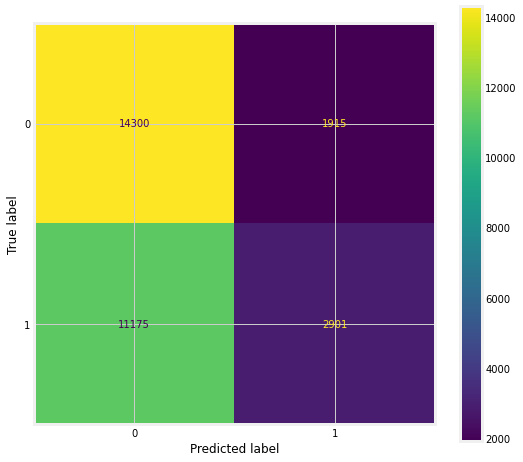

In [ ]:
cm = confusion_matrix(y_valid, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=lgm_model.classes_)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)                              

Построим график precision/recall

In [ ]:
precision, recall, _ = precision_recall_curve(y_valid, preds)

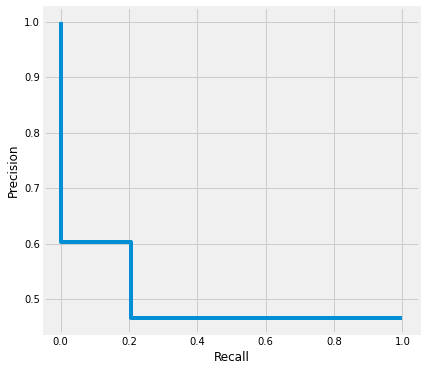

In [ ]:
disp = PrecisionRecallDisplay(precision=precision, recall=recall)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax) 

Найдем feature importance нашей модели

In [ ]:
pd.Series(lgm_model.feature_importances_, index=feature_names).sort_values(ascending=False)

num__distance                                            1071
cat__vehicle_type_hatchback                               150
cat__vehicle_type_coupe                                   147
cat__vehicle_transmission_auto                            144
cat__vehicle_age_3                                        113
cat__lighting_daylight                                    112
cat__location_type_ramp                                   107
cat__vehicle_type_minivan                                 105
cat__cellphone_in_use_0                                    99
cat__vehicle_type_sedan                                    97
cat__vehicle_age_2                                         86
cat__lighting_dark with no street lights                   84
cat__weather_1_clear                                       76
cat__vehicle_age_1                                         70
cat__lighting_dusk or dawn                                 58
cat__location_type_highway                                 43
cat__wea

Distance считается моделью самым значимым параметром. Посмотрим для него график зависимости для таргета

(0.0, 4000.0)

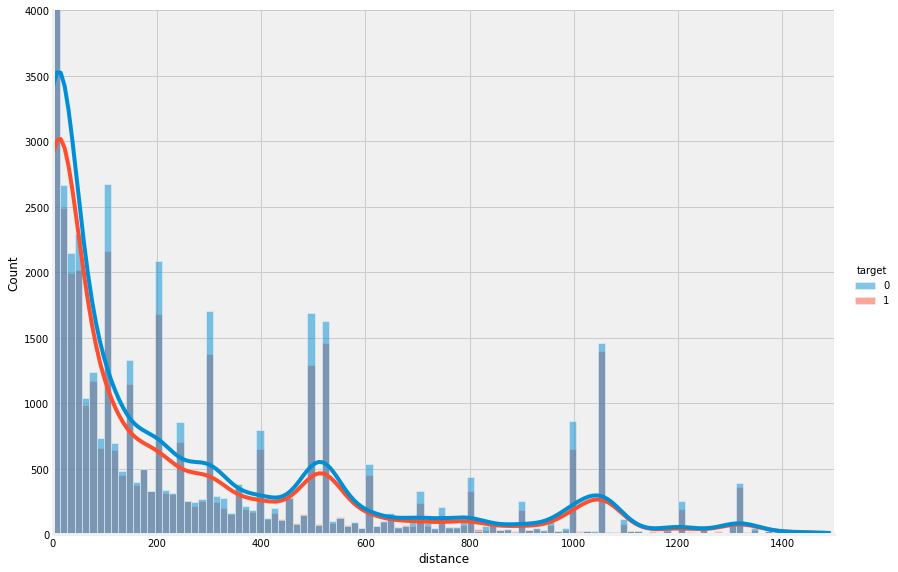

In [ ]:
df = X.copy()
df['target'] = y
sns.displot(data=df, x="distance", hue='target', kde=True, height=8, aspect=1.5)
plt.xlim(0, 1500)
plt.ylim(0, 4000)
# figure size in inches


По нему сложно интерпретировать результат, но можно сказать, что плотности распределения на больших дистанциях сильнее сближаются, следовательно вероятность аварии возрастает. С другой стороны, у нас таких примеров в разы меньше, чем на меньшие дистанции

## Общий вывод

Целью исследования было построение модели, указывающией водителю каршеринга на вероятность возможной аварии по пути. Нам были даны исторические данные аварий одного из регионов. С моей точки зрения этого мало, т.к нам нужно не только понять будет ли этот конкретный водитель виновником происшедствия, но и общий шанс того, что авария может произойти, не обязательно по его вине. Для этого нужно собрать не только данные, где авария произошла, но и где ее в похожих случаях не случилось, и поездка прошла успешно. И дальше нужно искать различия в причинах того или иного исхода.<br>

В нашей ситуации мы построили модель, которая только может определять, если случится авария, она случится по вине клиента или нет. Сама модель получилась плохого качества. Recall для "1" класса равняется 0.2. Это значит, что она определяет только одну пятую всех случаев с виной водителя. Precision тоже низкий, чуть выше 50%, т.е среди найденных "1" только половина верна, это как бросок монетки.<br>

Лучшая модель получилась lightgbm. Самым значимым параметром она считает дистанцию маршрута, что интуитивно кажется верным. Можно сделать систему, подсказывающую клиенту через какое-то количество киллометров остановиться и сделать отдых, если он долго находится за рулем.
